


For Camera #1
Loading calibration/cam1.xml
undistort_pt_by_pt took: 427 ms.
   Total # of occurrences: 307200
      0 : 73686
      1 : 172196
      2 : 51551
      3 : 9767



For Camera #2
Loading calibration/cam2.xml
undistort_pt_by_pt took: 425 ms.
   Total # of occurrences: 307200
      0 : 35096
      1 : 239816
      2 : 29853
      3 : 2435



For Camera #3
Loading calibration/cam3.xml
undistort_pt_by_pt took: 431 ms.
   Total # of occurrences: 307200
      0 : 47821
      1 : 216867
      2 : 37976
      3 : 4536


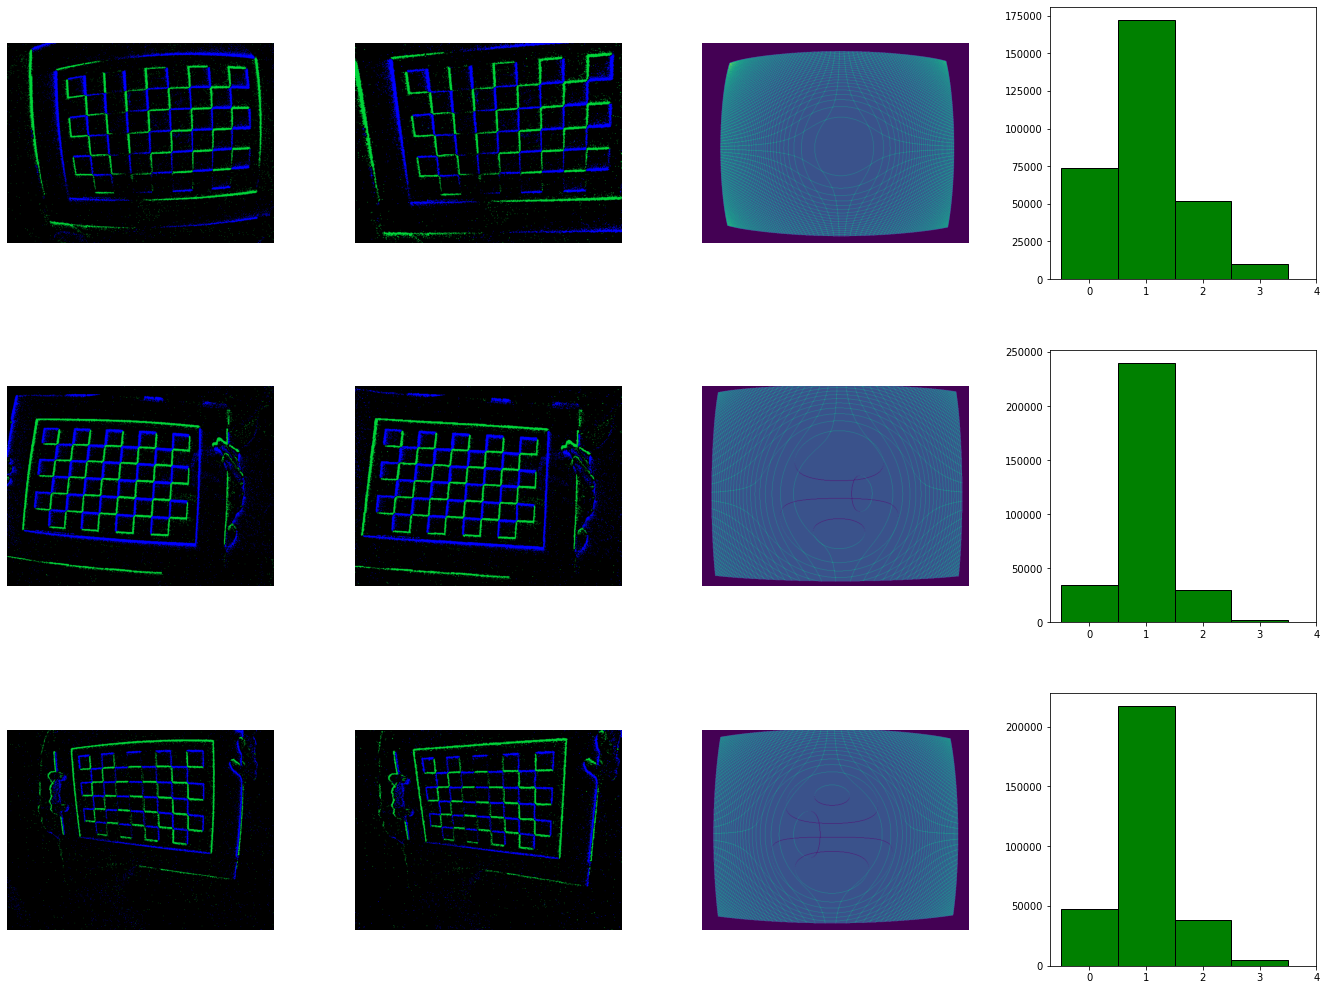

<Figure size 432x288 with 0 Axes>

In [1]:

%matplotlib inline

import xml.etree.ElementTree as ET
import re
import numpy as np
import time
import cv2 as cv
import glob
import matplotlib.image as mpimg
from numpy import genfromtxt
import matplotlib.pyplot as plt\

import matplotlib.mlab as mlab



'''
For camera N: load params from cam<N>.xml and use distorted_<N>.png to create distortion maps
The distortion maps are saved in mapx_cam<N>.csv and mapy_cam<N>.csv
Two undistortion procedures are performed (to validate the maps): with and without 'cv'
'''

def load_params(filename):

    tree = ET.parse(filename)
    root = tree.getroot()

    w = int(root[0][2].text) # number of columns in camera sensor
    h = int(root[0][3].text) # number of rows in camera sensor

    # Regular expression to get values out of *.xml
    rescinot = re.compile('[-+]?[\d]+\.?[\d]*[Ee](?:[-+]?[\d]+)?|[\d]')

    # Get Camera Matrix 
    cam_m = np.array(re.findall(rescinot, root[0][0][3].text))

    # Get Distortion Coefficients
    d_coeff = np.array(re.findall(rescinot, root[0][1][3].text))

    # Refactoring matrices and coefficients
    cam_m = cam_m.astype(np.float64).reshape((3,3))
    d_coeff = d_coeff.astype(np.float64)
    
    return w, h, cam_m, d_coeff


def plot_all(camera_id, axs, distorted, undistorted, occurrences, stats):
    
    axs[camera_id-1, 0].axis('off')
    axs[camera_id-1, 1].axis('off')
    axs[camera_id-1, 2].axis('off')
    axs[camera_id-1, 3].axis('on')
    axs[camera_id-1, 0].imshow(distorted)
    axs[camera_id-1, 1].imshow(undistorted)  
    axs[camera_id-1, 2].imshow(occurrences) 
    
    bin_array = range(np.amax(occurrences+1))
    n, bins, patches = axs[camera_id-1, 3].hist(stats, bins=bin_array, facecolor='green', alpha=1, align='left',edgecolor='black')
    axs[camera_id-1, 3].axes.set_xticks(bin_array, minor=False)
    
    print("   Total # of occurrences: %d" %(np.sum(occurrences)))
    for i in range(len(bins)-1):
        print("      %d : %d" %(bins[i], n[i]))

    
    
def get_distortion_maps(camera_id, z):
     
    # Reading parameters from *.xml
    w, h, cam_m, d_coeff = load_params("calibration/cam" + str(camera_id) + ".xml")
    print("Loading %s" %("calibration/cam" + str(camera_id) + ".xml"))
        
    # Undistorting stuff ...
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(cam_m, d_coeff, (h,w), z, (h,w))
    mapx, mapy = cv.initUndistortRectifyMap(cam_m, d_coeff, None, newcameramtx, (w,h), 5)
    
    
    np.savetxt("mapx_cam" + str(camera_id) + ".csv", mapx, delimiter=",")
    np.savetxt("mapy_cam" + str(camera_id) + ".csv", mapy, delimiter=",")
    
    return mapx, mapy
 
def undistort_pt_by_pt(distorted, mapx, mapy):
    
    x = distorted.shape[1]
    y = distorted.shape[0]
    
    occurrences = np.zeros((y,x), dtype=int)
    undistorted = np.zeros(distorted.shape, dtype=int)
    
    for i in range(x): #640
        for j in range(y): #480            
            old_x = int(mapx[j, i]) # WARNING: might be [j, i] ...
            old_y = int(mapy[j, i]) # WARNING: might be [j, i] ...
            if ((old_x>=0) and (old_x<x)) and ((old_y>=0) and (old_y<y)):
                undistorted[j, i, :] = distorted[old_y, old_x, :]
                occurrences[old_y, old_x] += 1
    
    return undistorted, occurrences
                

def count_pixel_occurrences(camera_id, img_name, z):
    
    # Which image?
    distorted = cv.imread(img_name)    

    # Get distortion maps
    mapx, mapy = get_distortion_maps(camera_id, z)

    # Get undistorted image (using distortion maps)
    start = time.time()
    undistorted, occurrences = undistort_pt_by_pt(distorted, mapx, mapy)
    stop = time.time()
    elapsed = stop - start
    print("undistort_pt_by_pt took: " + str(int(1000*elapsed)) + " ms.")


    return distorted, undistorted, occurrences

def get_stats(occurrences):
    stats = np.reshape(occurrences, (occurrences.shape[0]*occurrences.shape[1],1))
    return stats
    
if __name__ == "__main__":
    
    z = 0
    
    
    fig, axs = plt.subplots(3,4, figsize=(20,15))
    fig.tight_layout(pad=5.0)
    for camera_id in [1,2,3]:     
        print("\n\n\nFor Camera #%d" %(camera_id))
        img_name = "distorted_" + str(camera_id) + ".png"
        distorted, undistorted, occurrences = count_pixel_occurrences(camera_id, img_name, z)
        stats = get_stats(occurrences)
        plot_all(camera_id, axs, distorted, undistorted, occurrences, stats)
        
    
    plt.pause(1)
    plt.clf() 

